In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 100 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.2849
0 -> 5 -> 3 -> 17 -> 1 -> 12 -> 4 -> 18 -> 9 -> 16 -> 7 -> 2 -> 14 -> 6 -> 13 -> 11 -> 19 -> 8 -> 15 -> 10 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 141.69it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 151.58it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 123.79it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 60.81it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-5, num_epochs+5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 200
log_step = 10

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e-2):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with Clarabel

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 03 11:00:03 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 229.1573%, Val Regret: 226.7782%


Epoch    9, Loss:  -0.8246:   5%|██▋                                                  | 10/200 [00:30<06:56,  2.19s/it]

Epoch  10, Train Regret:  14.0162%, Val Regret:  18.7487%


Epoch   19, Loss:  -0.8836:  10%|█████▎                                               | 20/200 [00:53<06:09,  2.05s/it]

Epoch  20, Train Regret:  15.0899%, Val Regret:  16.5826%


Epoch   29, Loss:  -0.9304:  15%|███████▉                                             | 30/200 [01:14<05:43,  2.02s/it]

Epoch  30, Train Regret:  14.8948%, Val Regret:  15.9154%


Epoch   39, Loss:  -0.9332:  20%|██████████▌                                          | 40/200 [01:36<05:14,  1.97s/it]

Epoch  40, Train Regret:  14.2241%, Val Regret:  14.6657%


Epoch   49, Loss:  -0.8943:  25%|█████████████▎                                       | 50/200 [01:58<05:03,  2.02s/it]

Epoch  50, Train Regret:  14.0204%, Val Regret:  15.4284%


Epoch   59, Loss:  -0.9370:  30%|███████████████▉                                     | 60/200 [02:19<04:29,  1.92s/it]

Epoch  60, Train Regret:  13.8157%, Val Regret:  14.8729%


Epoch   69, Loss:  -0.9412:  35%|██████████████████▌                                  | 70/200 [02:40<04:58,  2.29s/it]


Epoch  70, Train Regret:  13.1633%, Val Regret:  15.1904%

Early Stop!

Evaluation:
Test Regret: 15.4577%
Training Elapsed Time: 75.47 Sec


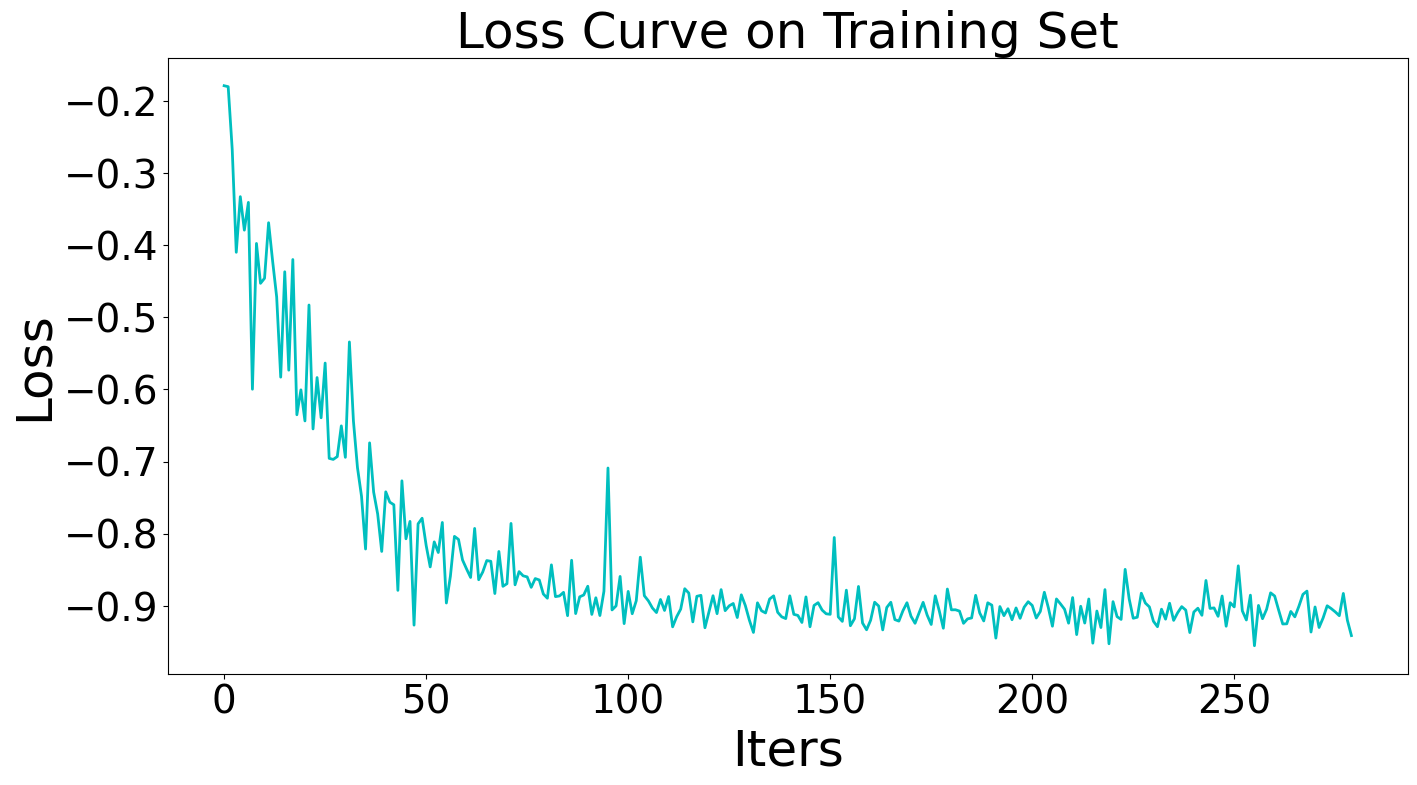

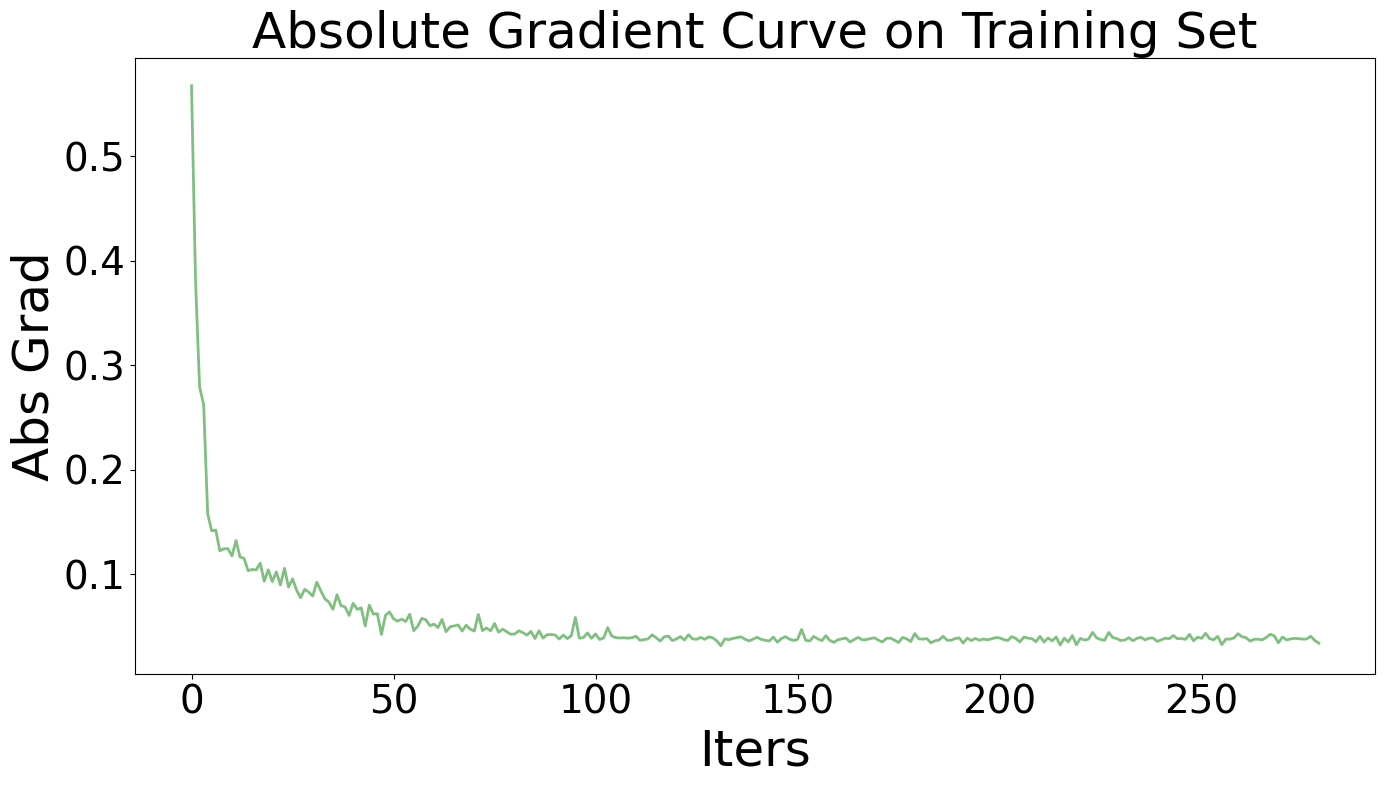

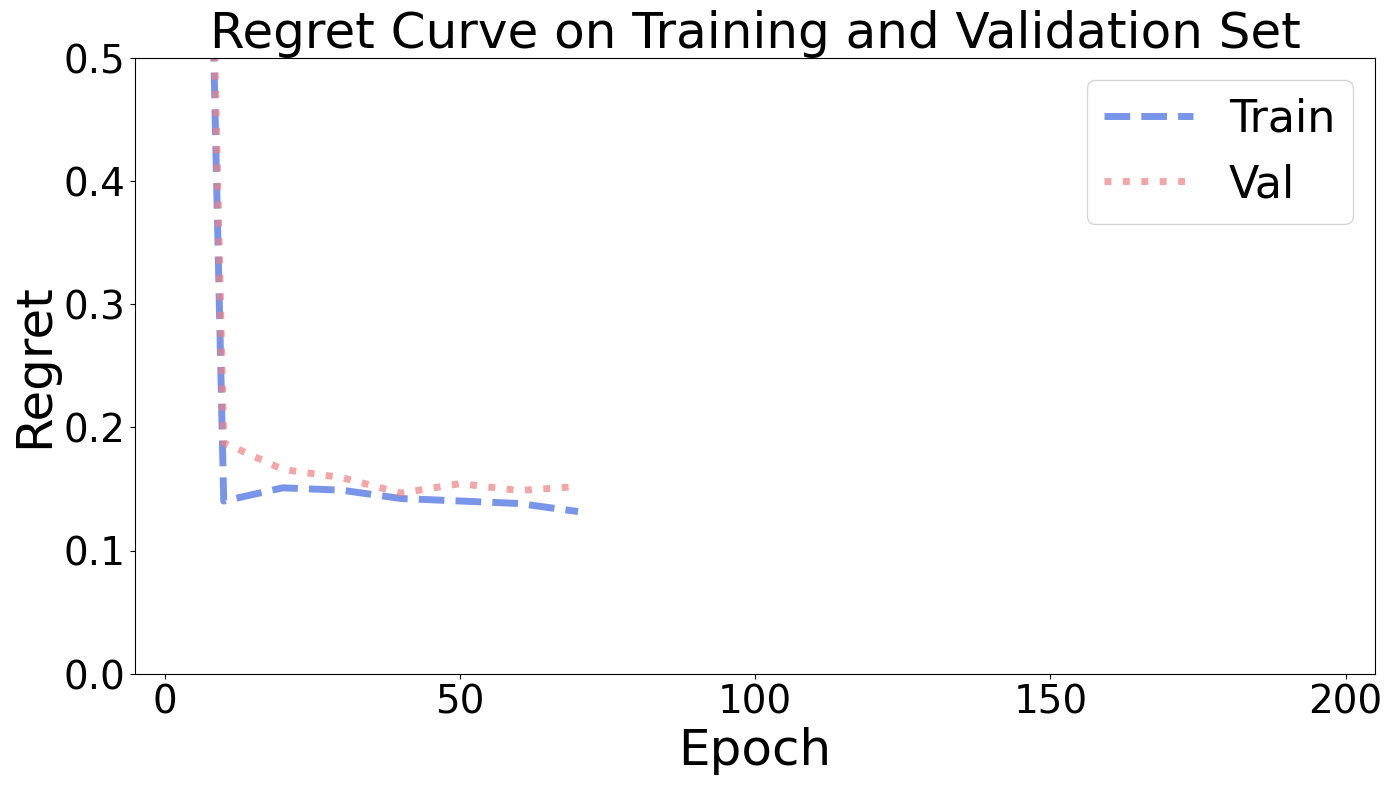

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:02<?, ?it/s]

Epoch   0, Train Regret: 213.6341%, Val Regret: 203.9659%


Epoch    9, Loss:  -0.8248:   5%|██▋                                                  | 10/200 [00:23<06:17,  1.99s/it]

Epoch  10, Train Regret:  13.7277%, Val Regret:  17.5303%


Epoch   19, Loss:  -0.8836:  10%|█████▎                                               | 20/200 [00:45<05:53,  1.96s/it]

Epoch  20, Train Regret:  15.0546%, Val Regret:  16.5336%


Epoch   29, Loss:  -0.9304:  15%|███████▉                                             | 30/200 [01:06<05:31,  1.95s/it]

Epoch  30, Train Regret:  14.2564%, Val Regret:  15.8168%


Epoch   39, Loss:  -0.9332:  20%|██████████▌                                          | 40/200 [01:28<05:34,  2.09s/it]

Epoch  40, Train Regret:  13.8797%, Val Regret:  14.7143%


Epoch   49, Loss:  -0.8942:  25%|█████████████▎                                       | 50/200 [01:50<04:56,  1.98s/it]

Epoch  50, Train Regret:  13.7616%, Val Regret:  15.1177%


Epoch   59, Loss:  -0.9368:  30%|███████████████▉                                     | 60/200 [02:11<04:39,  2.00s/it]

Epoch  60, Train Regret:  13.5727%, Val Regret:  14.7560%


Epoch   69, Loss:  -0.9411:  35%|██████████████████▌                                  | 70/200 [02:32<04:43,  2.18s/it]


Epoch  70, Train Regret:  12.9603%, Val Regret:  14.9731%

Early Stop!

Evaluation:
Test Regret: 15.4862%
Training Elapsed Time: 67.41 Sec


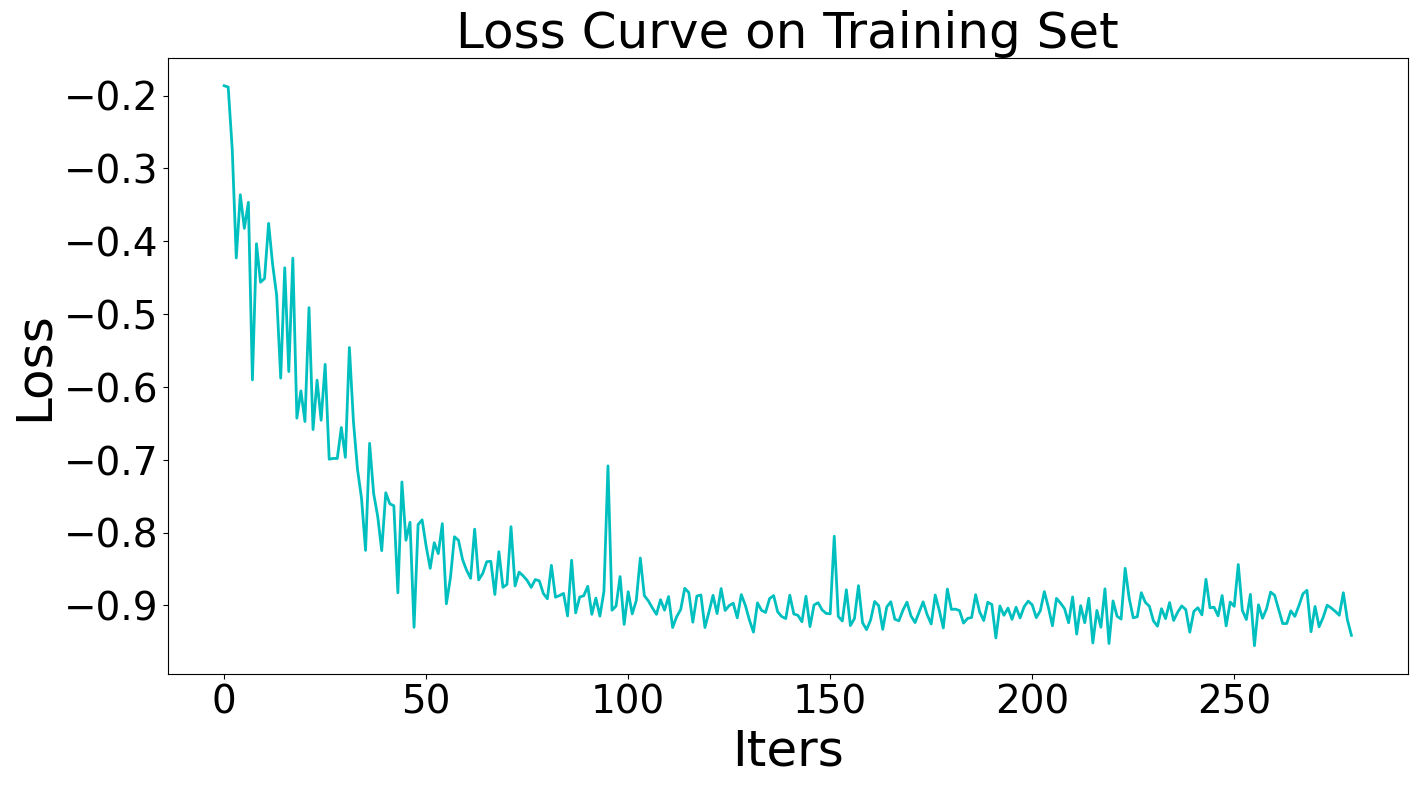

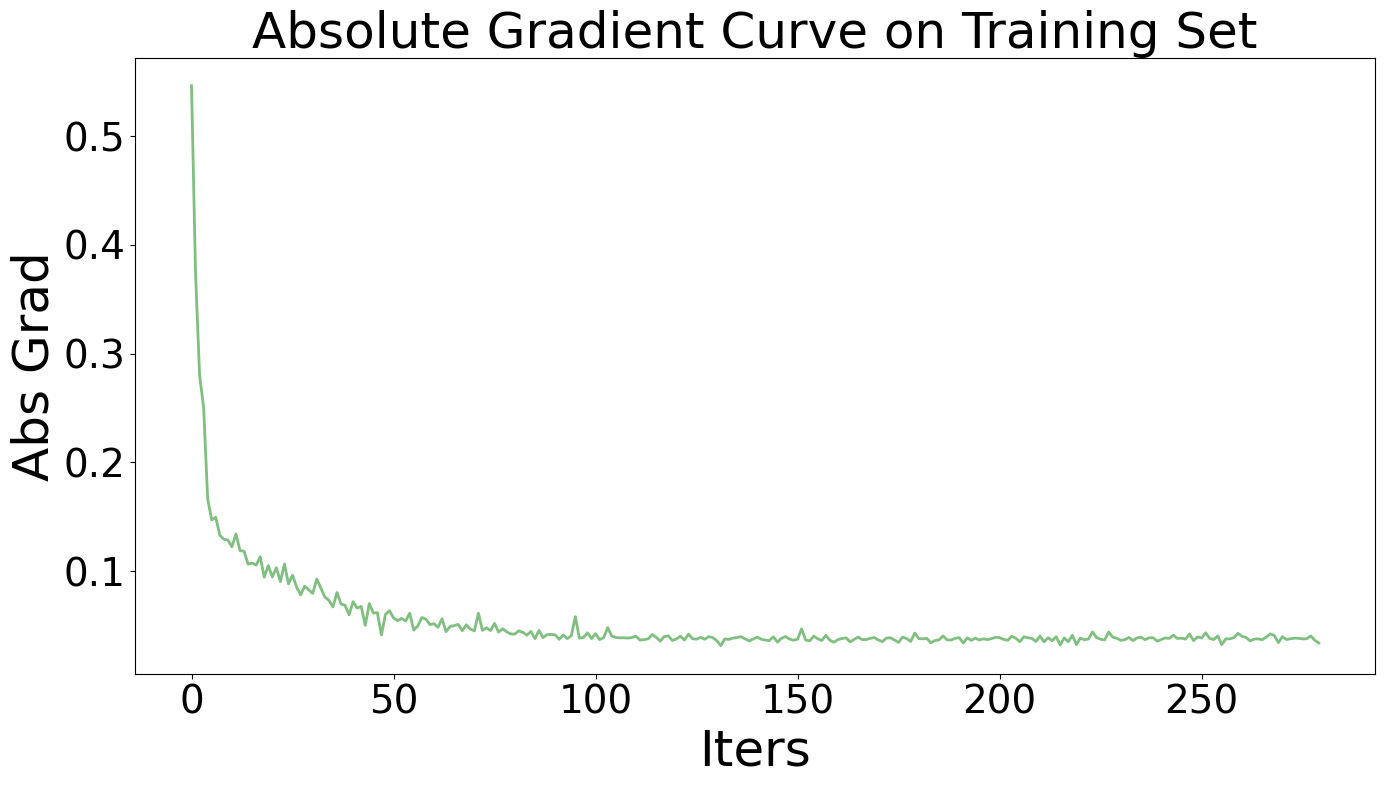

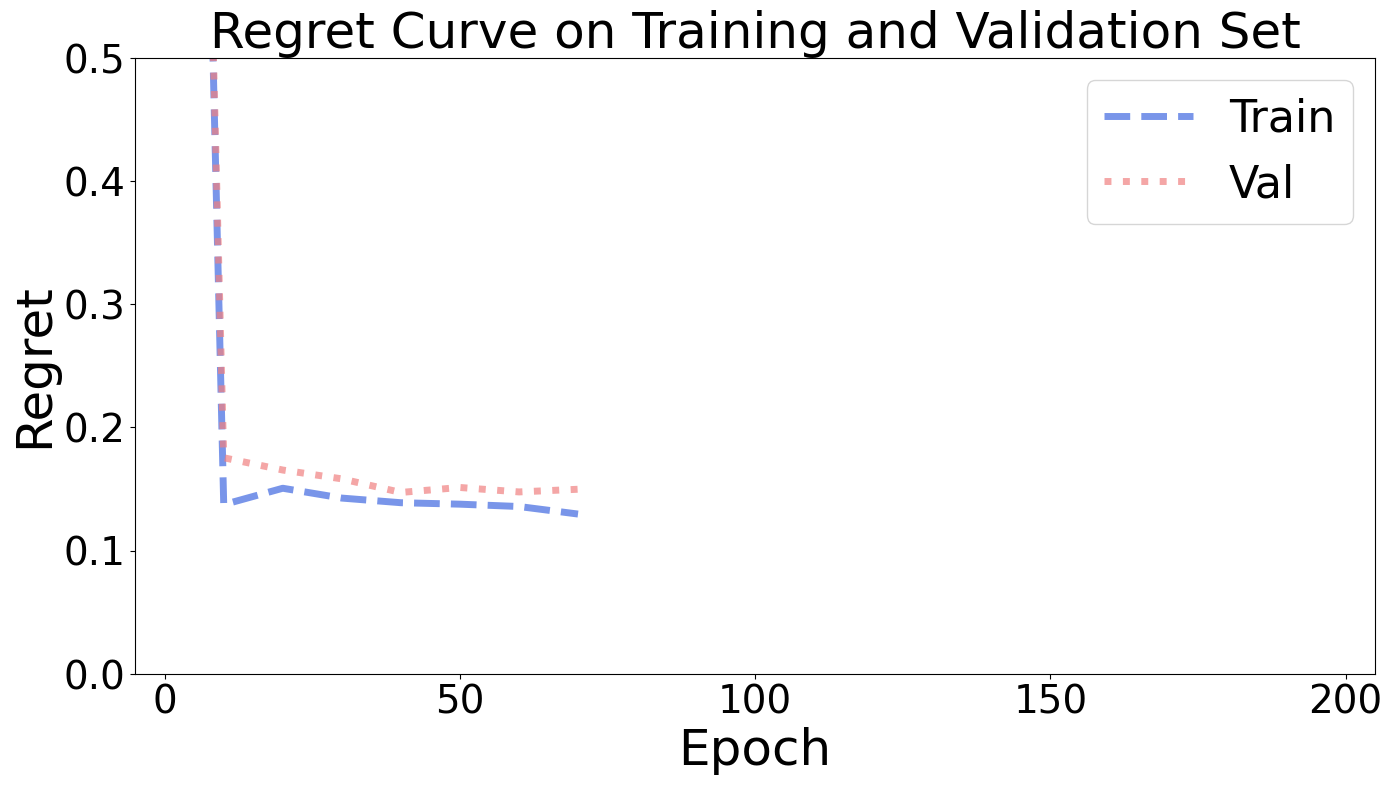

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

Num of cores: 1


In [22]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 213.6341%, Val Regret: 203.9659%


Epoch    9, Loss:   0.4752:   5%|██▋                                                  | 10/200 [00:14<03:28,  1.10s/it]

Epoch  10, Train Regret:  57.9243%, Val Regret:  76.3040%


Epoch   19, Loss:  -0.2620:  10%|█████▎                                               | 20/200 [00:26<03:17,  1.10s/it]

Epoch  20, Train Regret:  14.7698%, Val Regret:  28.2812%


Epoch   29, Loss:   0.1353:  15%|███████▉                                             | 30/200 [00:39<03:08,  1.11s/it]

Epoch  30, Train Regret:   9.6101%, Val Regret:  17.3033%


Epoch   39, Loss:  -0.4442:  20%|██████████▌                                          | 40/200 [00:51<02:59,  1.12s/it]

Epoch  40, Train Regret:   8.5751%, Val Regret:  15.9321%


Epoch   49, Loss:  -0.2349:  25%|█████████████▎                                       | 50/200 [01:04<02:48,  1.12s/it]

Epoch  50, Train Regret:   8.7712%, Val Regret:  16.0403%


Epoch   59, Loss:  -0.1003:  30%|███████████████▉                                     | 60/200 [01:17<02:34,  1.11s/it]

Epoch  60, Train Regret:   9.3696%, Val Regret:  15.8157%


Epoch   69, Loss:  -0.2248:  35%|██████████████████▌                                  | 70/200 [01:29<02:23,  1.10s/it]

Epoch  70, Train Regret:   8.6634%, Val Regret:  14.8366%


Epoch   79, Loss:  -0.2344:  40%|█████████████████████▏                               | 80/200 [01:42<02:11,  1.10s/it]

Epoch  80, Train Regret:   8.0624%, Val Regret:  15.5679%


Epoch   89, Loss:  -0.2421:  45%|███████████████████████▊                             | 90/200 [01:54<02:01,  1.11s/it]

Epoch  90, Train Regret:   7.7267%, Val Regret:  13.3562%


Epoch   99, Loss:  -0.0117:  50%|██████████████████████████                          | 100/200 [02:07<01:50,  1.10s/it]

Epoch 100, Train Regret:   7.1607%, Val Regret:  13.3393%


Epoch  109, Loss:  -0.3150:  55%|████████████████████████████▌                       | 110/200 [02:20<01:39,  1.11s/it]

Epoch 110, Train Regret:   6.5629%, Val Regret:  12.7039%


Epoch  119, Loss:  -0.2902:  60%|███████████████████████████████▏                    | 120/200 [02:32<01:28,  1.10s/it]

Epoch 120, Train Regret:   6.6212%, Val Regret:  12.2258%


Epoch  129, Loss:  -0.3488:  65%|█████████████████████████████████▊                  | 130/200 [02:45<01:16,  1.10s/it]

Epoch 130, Train Regret:   6.8242%, Val Regret:  12.1043%


Epoch  139, Loss:  -0.3967:  70%|████████████████████████████████████▍               | 140/200 [02:57<01:05,  1.10s/it]

Epoch 140, Train Regret:   6.3561%, Val Regret:  12.2039%


Epoch  149, Loss:  -0.3844:  75%|███████████████████████████████████████             | 150/200 [03:10<00:55,  1.10s/it]

Epoch 150, Train Regret:   6.1898%, Val Regret:  12.1159%


Epoch  159, Loss:  -0.2984:  80%|█████████████████████████████████████████▌          | 160/200 [03:22<00:44,  1.10s/it]

Epoch 160, Train Regret:   5.4993%, Val Regret:  11.7310%


Epoch  169, Loss:  -0.5433:  85%|████████████████████████████████████████████▏       | 170/200 [03:35<00:33,  1.10s/it]

Epoch 170, Train Regret:   5.6741%, Val Regret:  11.0550%


Epoch  179, Loss:  -0.5293:  90%|██████████████████████████████████████████████▊     | 180/200 [03:47<00:21,  1.10s/it]

Epoch 180, Train Regret:   5.7658%, Val Regret:  11.0994%


Epoch  189, Loss:  -0.3651:  95%|█████████████████████████████████████████████████▍  | 190/200 [04:00<00:10,  1.10s/it]

Epoch 190, Train Regret:   5.4439%, Val Regret:  10.5505%


Epoch  199, Loss:  -0.5641: 100%|████████████████████████████████████████████████████| 200/200 [04:11<00:00,  1.26s/it]


Epoch 199, Train Regret:   4.9973%, Val Regret:  10.6015%

Evaluation:
Test Regret: 11.1847%
Training Elapsed Time: 14.92 Sec


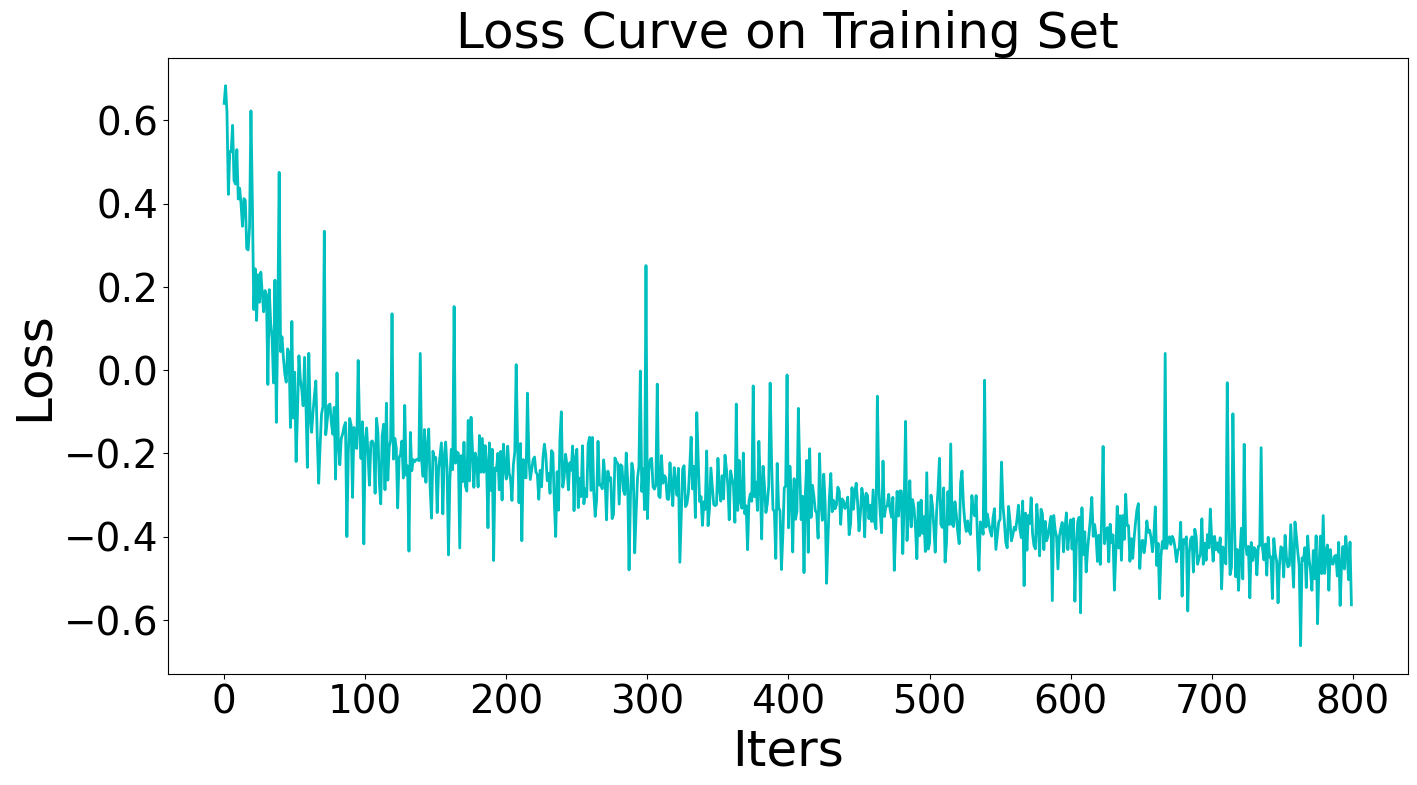

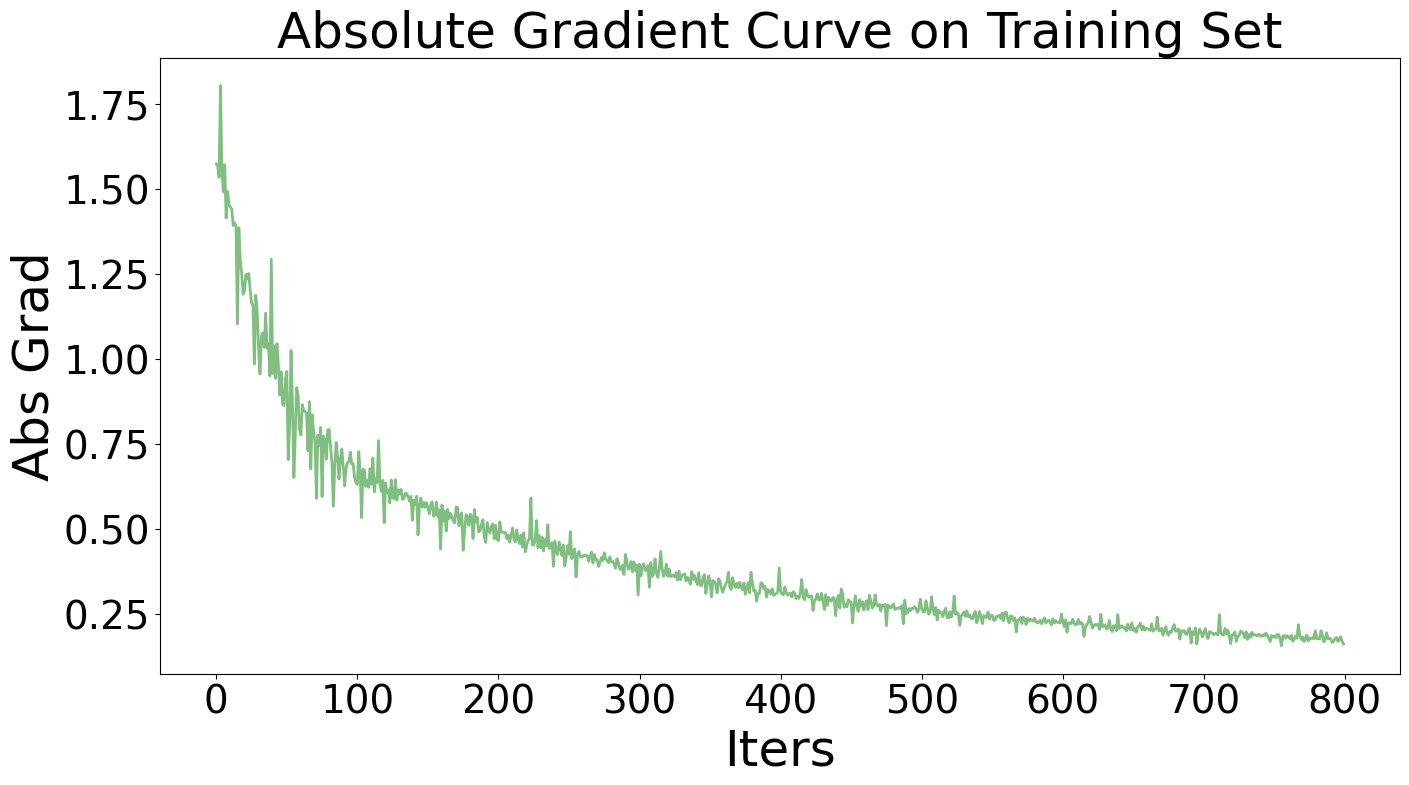

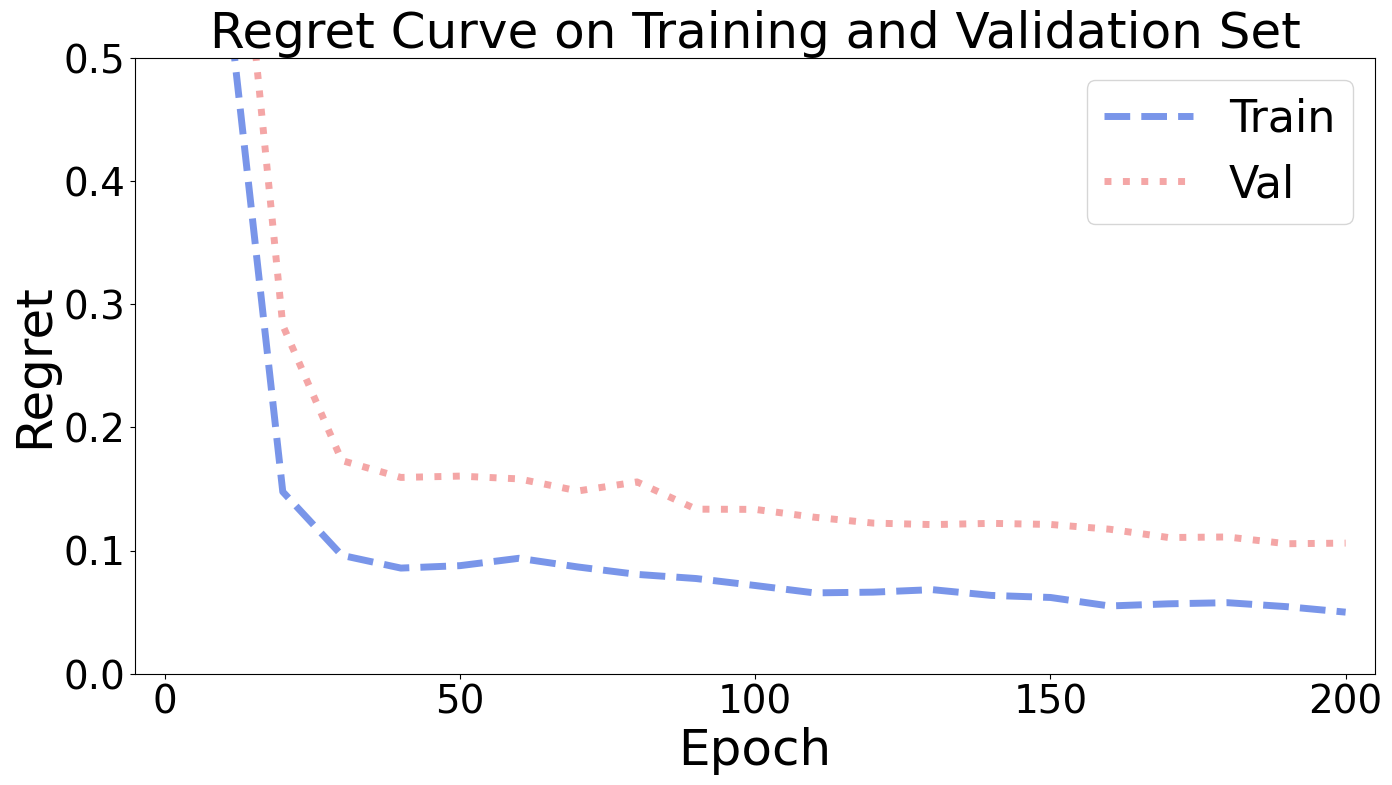

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, check_cone=True)

Num of cores: 1


In [26]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 216.2231%, Val Regret: 209.0881%


Epoch    9, Loss:   0.4765:   5%|██▋                                                  | 10/200 [00:17<04:25,  1.40s/it]

Epoch  10, Train Regret:  61.7867%, Val Regret:  80.7989%


Epoch   19, Loss:  -0.2632:  10%|█████▎                                               | 20/200 [00:32<04:17,  1.43s/it]

Epoch  20, Train Regret:  14.4981%, Val Regret:  27.5468%


Epoch   29, Loss:   0.0483:  15%|███████▉                                             | 30/200 [00:48<03:58,  1.41s/it]

Epoch  30, Train Regret:   9.7132%, Val Regret:  17.3168%


Epoch   39, Loss:  -0.4444:  20%|██████████▌                                          | 40/200 [01:04<03:56,  1.48s/it]

Epoch  40, Train Regret:   8.3519%, Val Regret:  16.0414%


Epoch   49, Loss:  -0.2376:  25%|█████████████▎                                       | 50/200 [01:20<03:30,  1.41s/it]

Epoch  50, Train Regret:   8.0306%, Val Regret:  14.7427%


Epoch   59, Loss:  -0.1476:  30%|███████████████▉                                     | 60/200 [01:35<03:20,  1.43s/it]

Epoch  60, Train Regret:   8.3551%, Val Regret:  15.2496%


Epoch   69, Loss:  -0.2728:  35%|██████████████████▌                                  | 70/200 [01:51<03:02,  1.40s/it]

Epoch  70, Train Regret:   6.8569%, Val Regret:  13.9450%


Epoch   79, Loss:  -0.2377:  40%|█████████████████████▏                               | 80/200 [02:07<02:55,  1.46s/it]

Epoch  80, Train Regret:   7.4663%, Val Regret:  12.9626%


Epoch   89, Loss:  -0.2887:  45%|███████████████████████▊                             | 90/200 [02:23<02:36,  1.42s/it]

Epoch  90, Train Regret:   6.7479%, Val Regret:  12.9347%


Epoch   99, Loss:  -0.0155:  50%|██████████████████████████                          | 100/200 [02:40<02:28,  1.49s/it]

Epoch 100, Train Regret:   6.0837%, Val Regret:  12.7500%


Epoch  109, Loss:  -0.3197:  55%|████████████████████████████▌                       | 110/200 [02:56<02:11,  1.46s/it]

Epoch 110, Train Regret:   6.0185%, Val Regret:  12.8557%


Epoch  119, Loss:  -0.3418:  60%|███████████████████████████████▏                    | 120/200 [03:12<01:54,  1.43s/it]

Epoch 120, Train Regret:   5.7442%, Val Regret:  11.3869%


Epoch  129, Loss:  -0.3993:  65%|█████████████████████████████████▊                  | 130/200 [03:28<01:38,  1.41s/it]

Epoch 130, Train Regret:   5.4778%, Val Regret:  10.9958%


Epoch  139, Loss:  -0.4025:  70%|████████████████████████████████████▍               | 140/200 [03:44<01:25,  1.43s/it]

Epoch 140, Train Regret:   5.1136%, Val Regret:  11.4699%


Epoch  149, Loss:  -0.4371:  75%|███████████████████████████████████████             | 150/200 [03:59<01:10,  1.41s/it]

Epoch 150, Train Regret:   4.9612%, Val Regret:  11.2598%


Epoch  159, Loss:  -0.3580:  80%|█████████████████████████████████████████▌          | 160/200 [04:15<00:57,  1.43s/it]

Epoch 160, Train Regret:   5.2826%, Val Regret:  10.6889%


Epoch  169, Loss:  -0.5934:  85%|████████████████████████████████████████████▏       | 170/200 [04:31<00:42,  1.42s/it]

Epoch 170, Train Regret:   5.1252%, Val Regret:  10.3833%


Epoch  179, Loss:  -0.5896:  90%|██████████████████████████████████████████████▊     | 180/200 [04:46<00:28,  1.41s/it]

Epoch 180, Train Regret:   4.9332%, Val Regret:  10.6569%


Epoch  189, Loss:  -0.4203:  95%|█████████████████████████████████████████████████▍  | 190/200 [05:02<00:14,  1.44s/it]

Epoch 190, Train Regret:   4.7451%, Val Regret:  10.8000%


Epoch  199, Loss:  -0.5685: 100%|████████████████████████████████████████████████████| 200/200 [05:16<00:00,  1.58s/it]


Epoch 199, Train Regret:   4.8192%, Val Regret:   9.6189%

Evaluation:
Test Regret: 10.8183%
Training Elapsed Time: 81.47 Sec


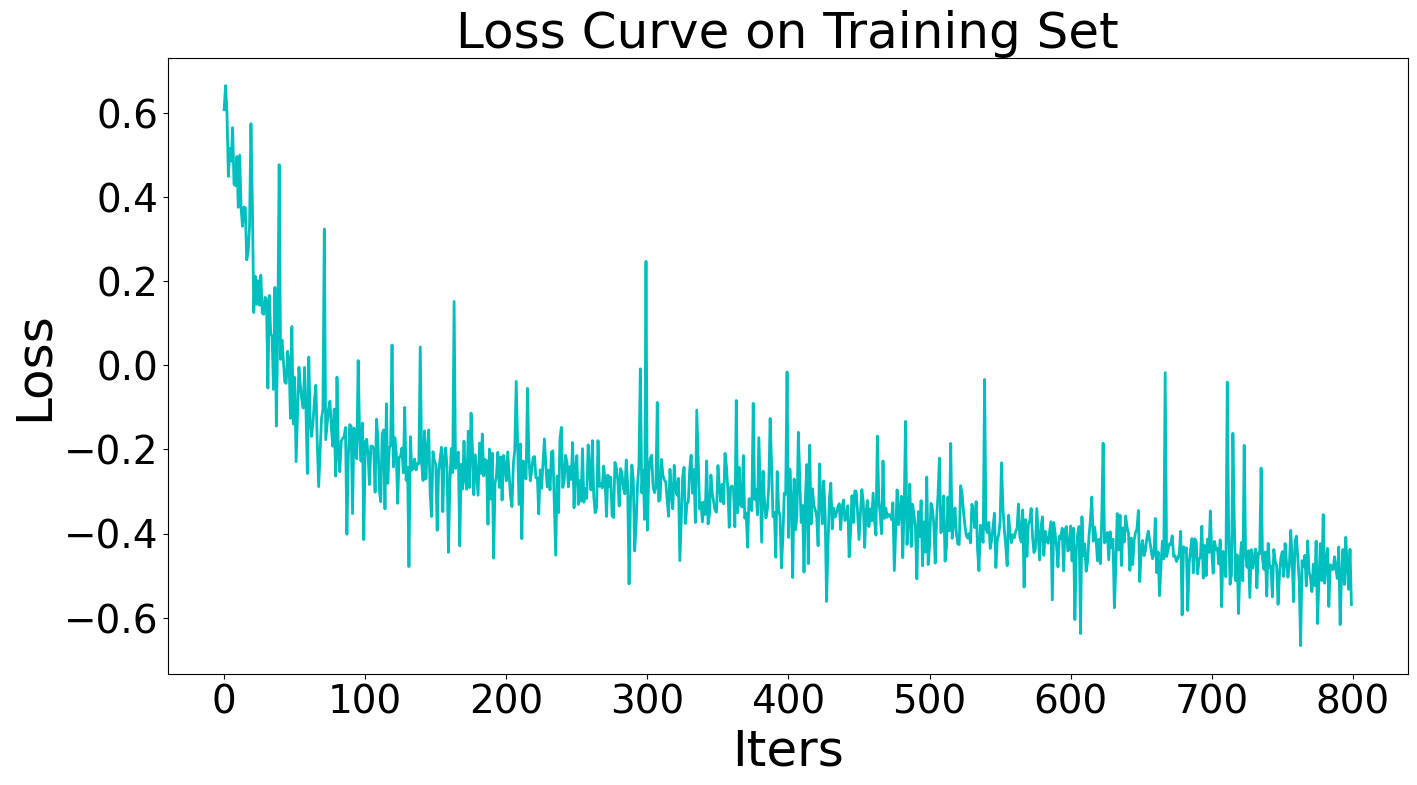

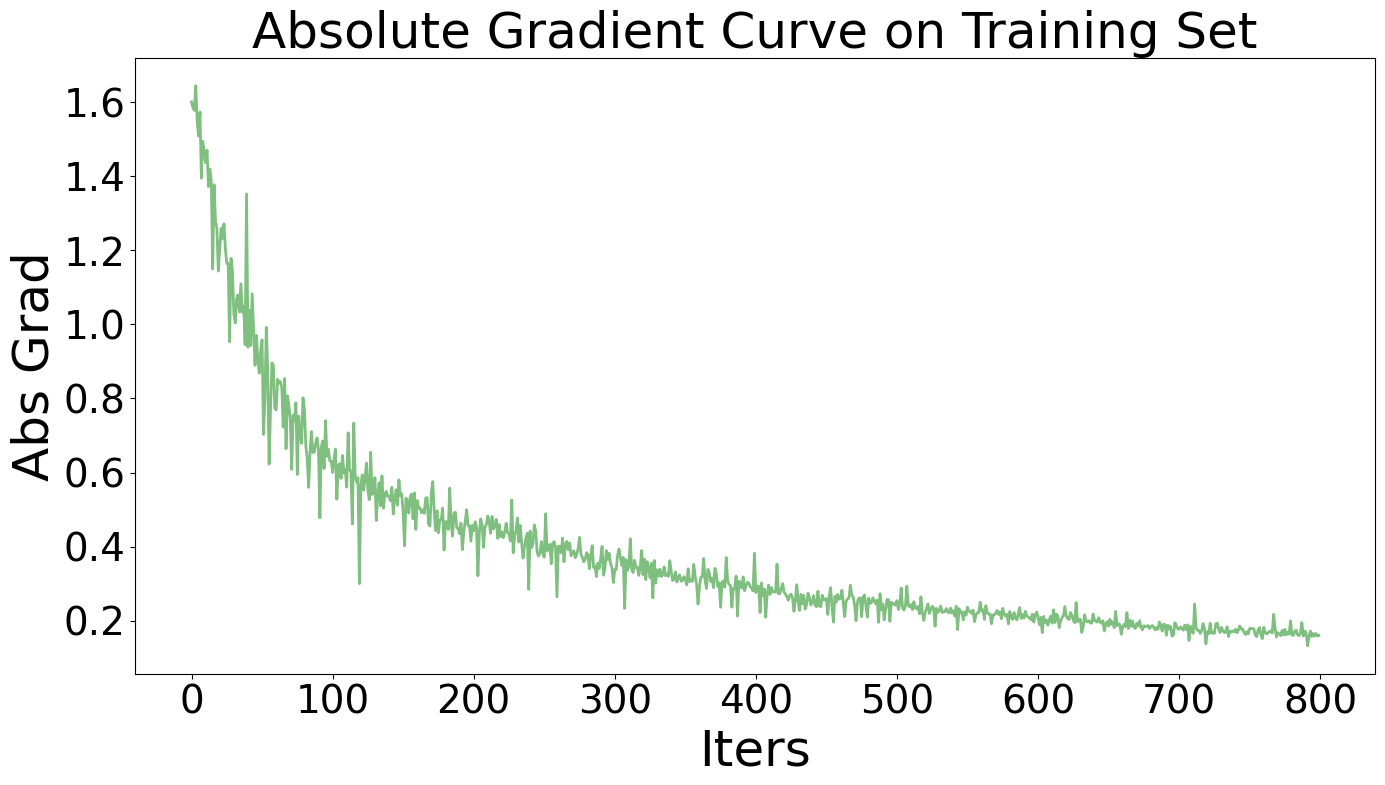

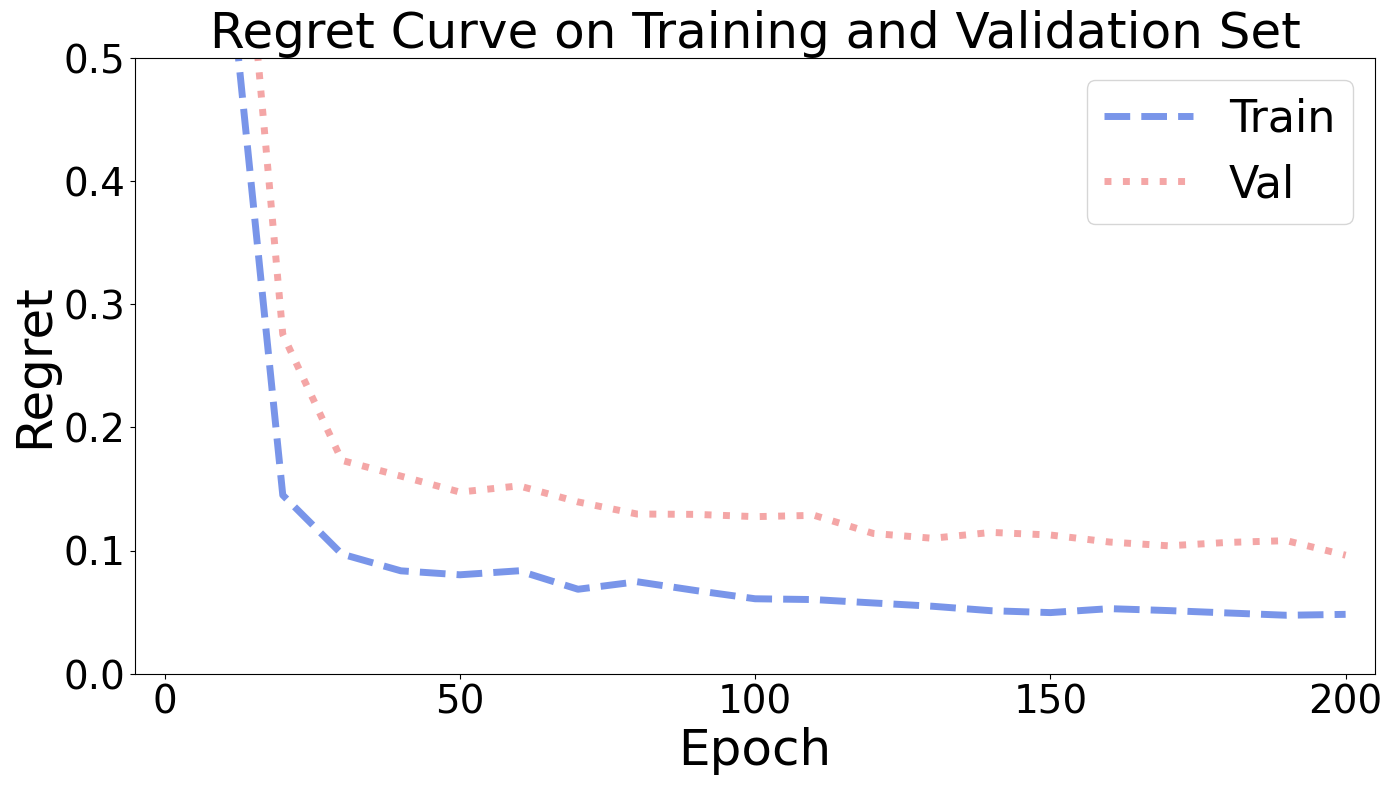

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

Num of cores: 1


In [30]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 216.2231%, Val Regret: 209.0881%


Epoch    9, Loss:  -0.1372:   5%|██▋                                                  | 10/200 [00:13<03:19,  1.05s/it]

Epoch  10, Train Regret:  52.5925%, Val Regret:  66.3349%


Epoch   19, Loss:  -0.2617:  10%|█████▎                                               | 20/200 [00:25<03:08,  1.05s/it]

Epoch  20, Train Regret:  11.3995%, Val Regret:  21.7065%


Epoch   29, Loss:  -0.3124:  15%|███████▉                                             | 30/200 [00:37<02:58,  1.05s/it]

Epoch  30, Train Regret:  11.0306%, Val Regret:  17.4948%


Epoch   39, Loss:  -0.3498:  20%|██████████▌                                          | 40/200 [00:49<02:48,  1.05s/it]

Epoch  40, Train Regret:   9.2126%, Val Regret:  17.4413%


Epoch   49, Loss:  -0.2682:  25%|█████████████▎                                       | 50/200 [01:01<02:37,  1.05s/it]

Epoch  50, Train Regret:   9.4475%, Val Regret:  17.2423%


Epoch   59, Loss:  -0.4274:  30%|███████████████▉                                     | 60/200 [01:13<02:27,  1.05s/it]

Epoch  60, Train Regret:   8.8416%, Val Regret:  17.0920%


Epoch   69, Loss:  -0.4605:  35%|██████████████████▌                                  | 70/200 [01:25<02:17,  1.05s/it]

Epoch  70, Train Regret:   8.3876%, Val Regret:  16.3335%


Epoch   79, Loss:  -0.3424:  40%|█████████████████████▏                               | 80/200 [01:37<02:06,  1.05s/it]

Epoch  80, Train Regret:   8.3290%, Val Regret:  16.7915%


Epoch   89, Loss:  -0.5632:  45%|███████████████████████▊                             | 90/200 [01:49<01:55,  1.05s/it]

Epoch  90, Train Regret:   7.9939%, Val Regret:  15.1938%


Epoch   99, Loss:  -0.3759:  50%|██████████████████████████                          | 100/200 [02:01<01:45,  1.05s/it]

Epoch 100, Train Regret:   7.4921%, Val Regret:  15.6369%


Epoch  109, Loss:  -0.5225:  55%|████████████████████████████▌                       | 110/200 [02:13<01:34,  1.05s/it]

Epoch 110, Train Regret:   7.7312%, Val Regret:  14.9023%


Epoch  119, Loss:  -0.2777:  60%|███████████████████████████████▏                    | 120/200 [02:25<01:23,  1.05s/it]

Epoch 120, Train Regret:   7.2189%, Val Regret:  13.7600%


Epoch  129, Loss:  -0.5519:  65%|█████████████████████████████████▊                  | 130/200 [02:37<01:13,  1.05s/it]

Epoch 130, Train Regret:   7.1024%, Val Regret:  13.2019%


Epoch  139, Loss:  -0.4845:  70%|████████████████████████████████████▍               | 140/200 [02:49<01:03,  1.05s/it]

Epoch 140, Train Regret:   7.0942%, Val Regret:  12.6303%


Epoch  149, Loss:  -0.3097:  75%|███████████████████████████████████████             | 150/200 [03:01<00:52,  1.05s/it]

Epoch 150, Train Regret:   7.1414%, Val Regret:  12.3852%


Epoch  159, Loss:  -0.2103:  80%|█████████████████████████████████████████▌          | 160/200 [03:13<00:41,  1.05s/it]

Epoch 160, Train Regret:   6.8560%, Val Regret:  12.6634%


Epoch  169, Loss:  -0.4399:  85%|████████████████████████████████████████████▏       | 170/200 [03:25<00:31,  1.05s/it]

Epoch 170, Train Regret:   6.7817%, Val Regret:  12.3190%


Epoch  179, Loss:  -0.6150:  90%|██████████████████████████████████████████████▊     | 180/200 [03:37<00:21,  1.06s/it]

Epoch 180, Train Regret:   6.7535%, Val Regret:  12.5088%


Epoch  189, Loss:  -0.5673:  95%|█████████████████████████████████████████████████▍  | 190/200 [03:49<00:10,  1.05s/it]

Epoch 190, Train Regret:   6.3215%, Val Regret:  12.1223%


Epoch  199, Loss:  -0.4031: 100%|████████████████████████████████████████████████████| 200/200 [03:59<00:00,  1.20s/it]


Epoch 199, Train Regret:   6.1136%, Val Regret:  11.9148%

Evaluation:
Test Regret: 12.3429%
Training Elapsed Time: 5.06 Sec


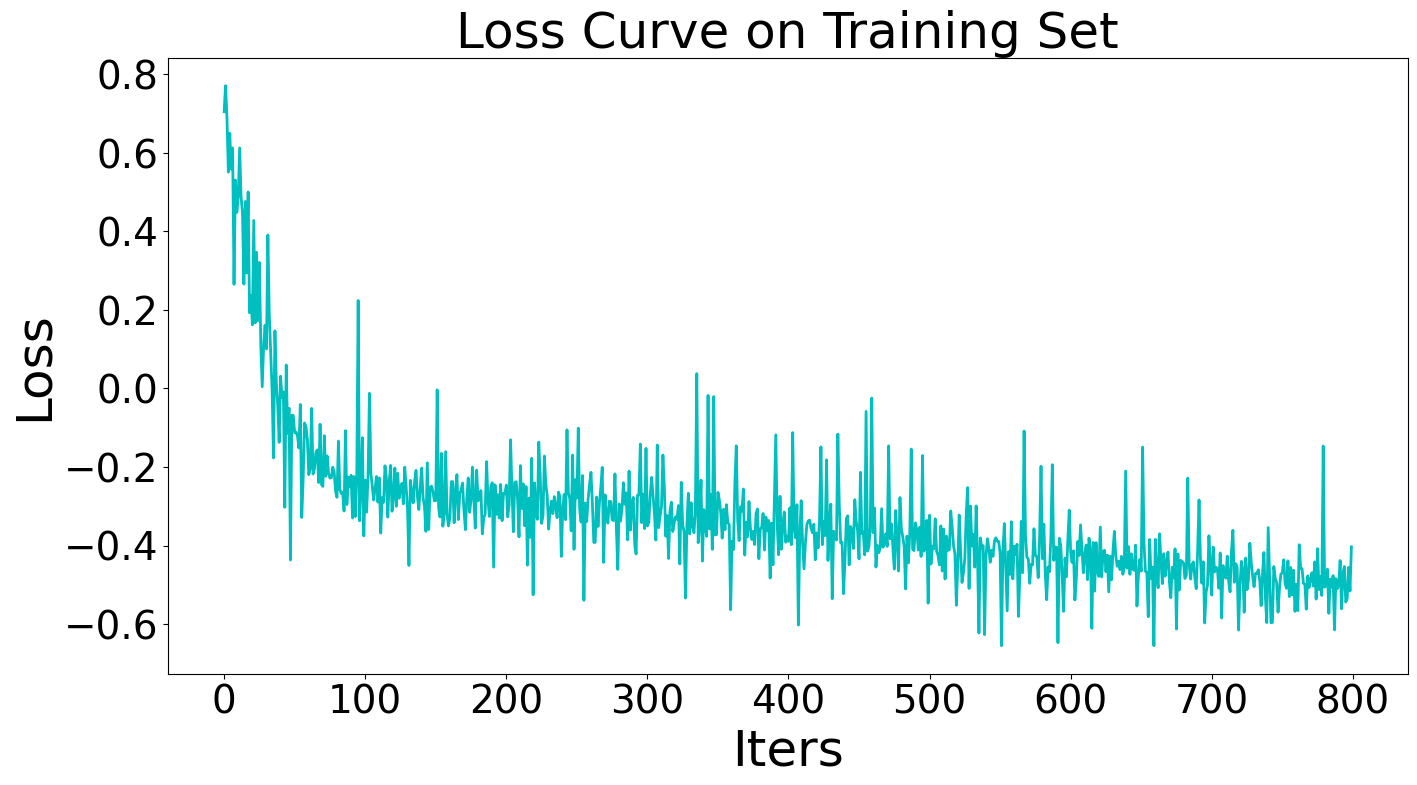

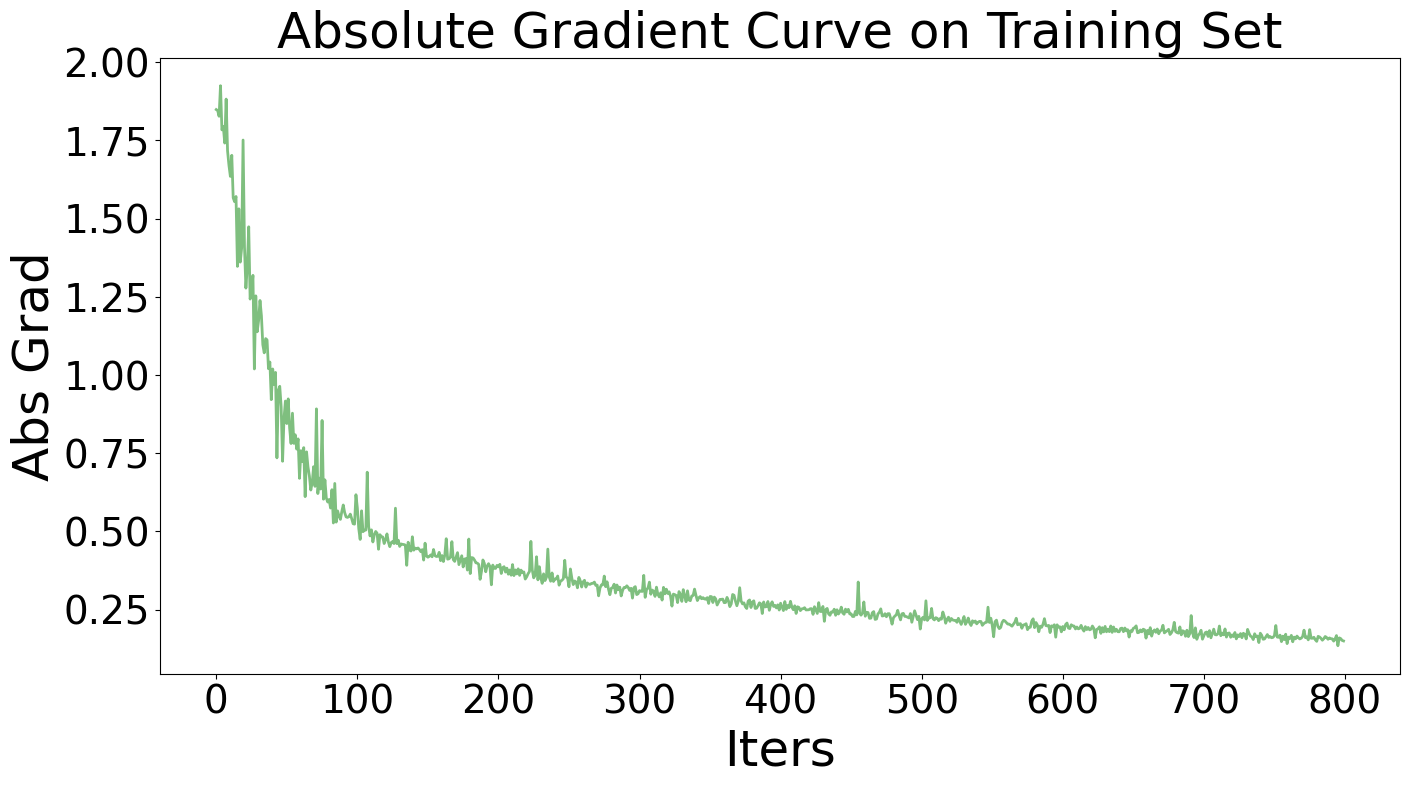

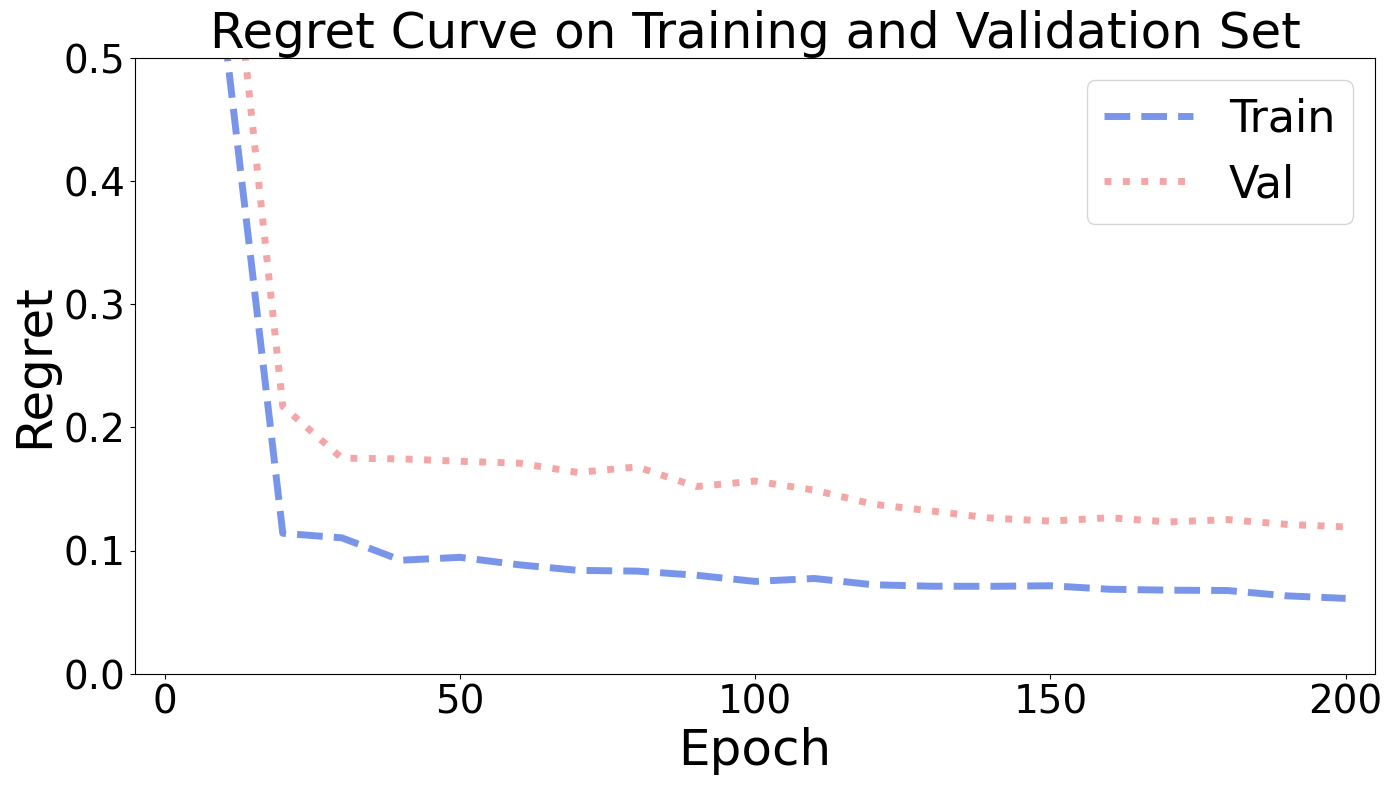

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, check_cone=True)

Num of cores: 1


In [34]:
lr = 1e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                          | 0/200 [00:01<?, ?it/s]

Epoch   0, Train Regret: 198.6120%, Val Regret: 197.8650%


Epoch    9, Loss:  -0.1693:   5%|██▋                                                  | 10/200 [00:16<04:20,  1.37s/it]

Epoch  10, Train Regret:  44.2940%, Val Regret:  60.2684%


Epoch   19, Loss:  -0.2591:  10%|█████▎                                               | 20/200 [00:31<04:07,  1.38s/it]

Epoch  20, Train Regret:  12.8745%, Val Regret:  22.1135%


Epoch   29, Loss:  -0.3275:  15%|███████▉                                             | 30/200 [00:47<03:53,  1.38s/it]

Epoch  30, Train Regret:  10.6129%, Val Regret:  17.6347%


Epoch   39, Loss:  -0.3504:  20%|██████████▌                                          | 40/200 [01:02<03:41,  1.38s/it]

Epoch  40, Train Regret:   8.6956%, Val Regret:  17.3345%


Epoch   49, Loss:  -0.2700:  25%|█████████████▎                                       | 50/200 [01:18<03:33,  1.43s/it]

Epoch  50, Train Regret:   8.3971%, Val Regret:  15.9901%


Epoch   59, Loss:  -0.4278:  30%|███████████████▉                                     | 60/200 [01:33<03:14,  1.39s/it]

Epoch  60, Train Regret:   8.3607%, Val Regret:  16.4446%


Epoch   69, Loss:  -0.4890:  35%|██████████████████▌                                  | 70/200 [01:49<03:01,  1.40s/it]

Epoch  70, Train Regret:   7.7632%, Val Regret:  15.7880%


Epoch   79, Loss:  -0.3661:  40%|█████████████████████▏                               | 80/200 [02:04<02:46,  1.39s/it]

Epoch  80, Train Regret:   7.1545%, Val Regret:  15.2452%


Epoch   89, Loss:  -0.5903:  45%|███████████████████████▊                             | 90/200 [02:20<02:35,  1.41s/it]

Epoch  90, Train Regret:   7.3025%, Val Regret:  15.4653%


Epoch   99, Loss:  -0.4060:  50%|██████████████████████████                          | 100/200 [02:35<02:17,  1.38s/it]

Epoch 100, Train Regret:   6.6671%, Val Regret:  14.4200%


Epoch  109, Loss:  -0.5512:  55%|████████████████████████████▌                       | 110/200 [02:51<02:06,  1.41s/it]

Epoch 110, Train Regret:   6.5191%, Val Regret:  14.7179%


Epoch  119, Loss:  -0.2811:  60%|███████████████████████████████▏                    | 120/200 [03:06<01:49,  1.37s/it]

Epoch 120, Train Regret:   6.1379%, Val Regret:  13.3436%


Epoch  129, Loss:  -0.5550:  65%|█████████████████████████████████▊                  | 130/200 [03:22<01:38,  1.41s/it]

Epoch 130, Train Regret:   6.3638%, Val Regret:  13.3573%


Epoch  139, Loss:  -0.5483:  70%|████████████████████████████████████▍               | 140/200 [03:38<01:26,  1.44s/it]

Epoch 140, Train Regret:   6.1326%, Val Regret:  13.2431%


Epoch  149, Loss:  -0.3175:  75%|███████████████████████████████████████             | 150/200 [03:54<01:11,  1.42s/it]

Epoch 150, Train Regret:   5.9660%, Val Regret:  12.1629%


Epoch  159, Loss:  -0.2188:  80%|█████████████████████████████████████████▌          | 160/200 [04:09<00:56,  1.40s/it]

Epoch 160, Train Regret:   6.1487%, Val Regret:  12.3971%


Epoch  169, Loss:  -0.5043:  85%|████████████████████████████████████████████▏       | 170/200 [04:25<00:42,  1.42s/it]

Epoch 170, Train Regret:   5.6115%, Val Regret:  12.3001%


Epoch  179, Loss:  -0.6122:  90%|██████████████████████████████████████████████▊     | 180/200 [04:40<00:28,  1.41s/it]

Epoch 180, Train Regret:   5.5059%, Val Regret:  11.6421%


Epoch  189, Loss:  -0.5962:  95%|█████████████████████████████████████████████████▍  | 190/200 [04:56<00:14,  1.41s/it]

Epoch 190, Train Regret:   5.4233%, Val Regret:  11.6444%


Epoch  199, Loss:  -0.4021: 100%|████████████████████████████████████████████████████| 200/200 [05:10<00:00,  1.55s/it]


Epoch 199, Train Regret:   5.7382%, Val Regret:  11.3870%

Evaluation:
Test Regret: 11.5597%
Training Elapsed Time: 73.59 Sec


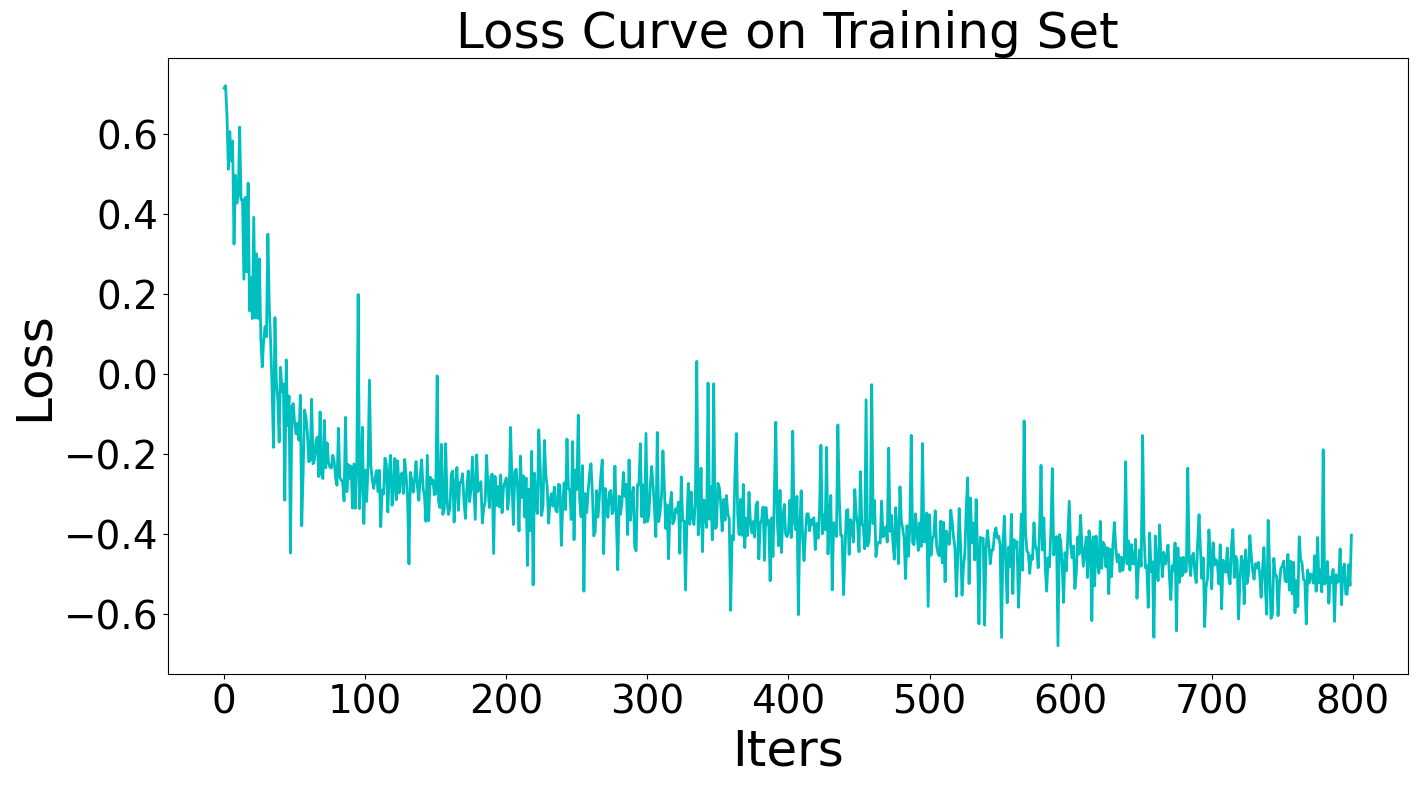

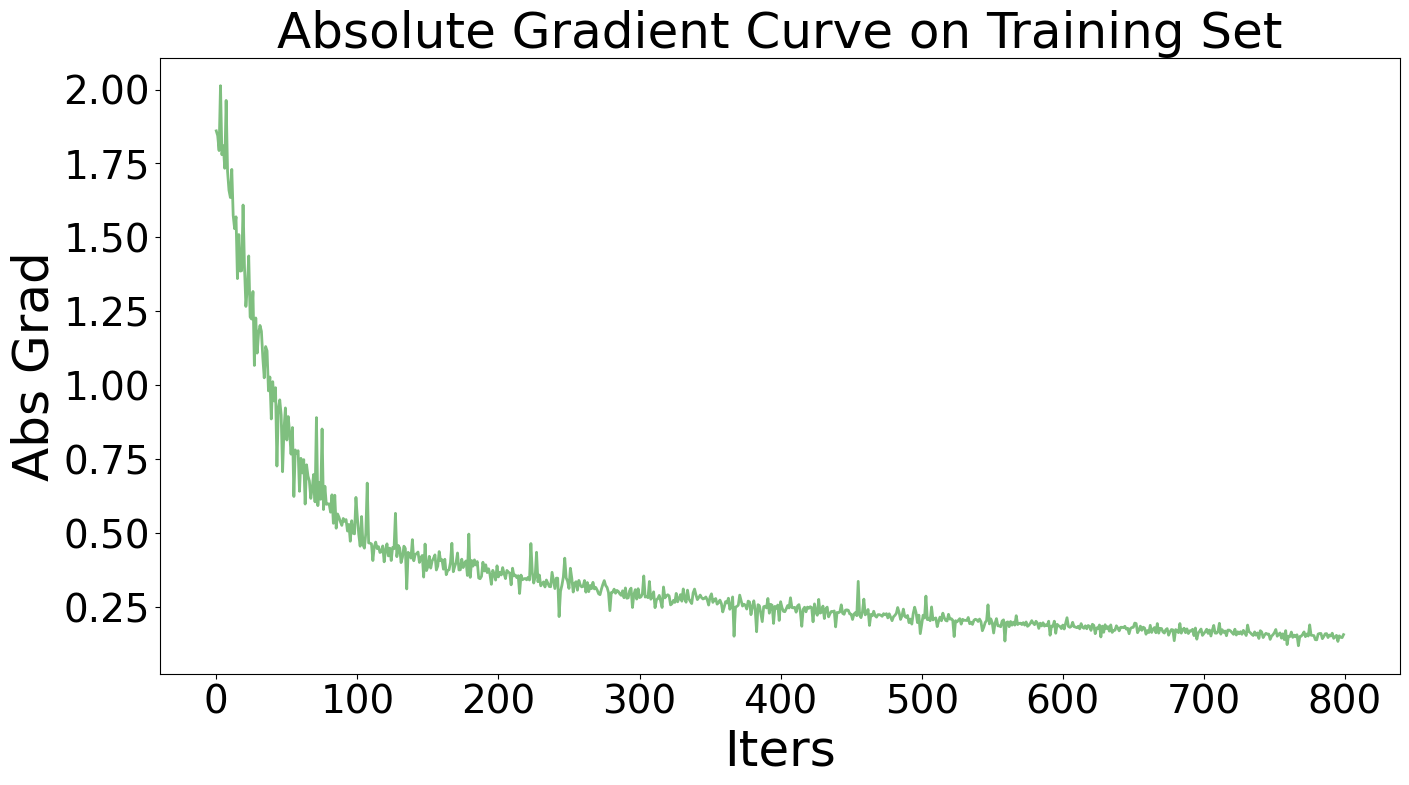

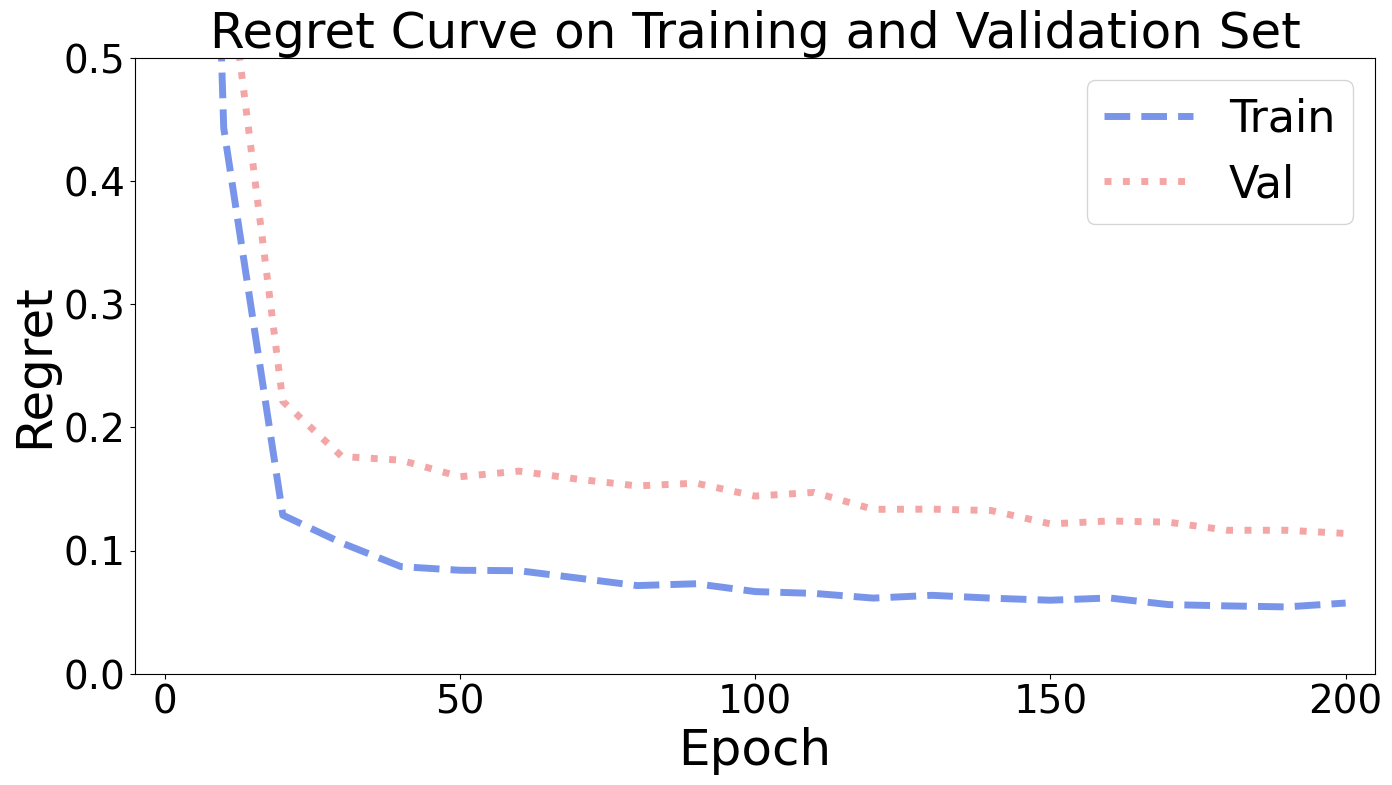

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)